# Twitter KNeighborsClassifier Machine Learning

In this project, we are going to use the K-Nearest Neighbor algorithm to predict whether a tweet will go viral. Before jumping into using the classifier, let's first consider the problem we're trying to solve. Which features of a tweet are most closely linked to its popularity?


Let's explore these options by looking at the data we have available to us.

In [1]:
# first lets start with the viral tweets
import pandas as pd

all_tweets = pd.read_json("random_tweets.json", lines=True)

print(len(all_tweets))
print(all_tweets.columns)
print(all_tweets.loc[0]['text'])

#Print the user here and the user's location here.
# print(all_tweets[['geo', 'id']].head(20))
print(all_tweets['user'].loc[0]['location'])

11099
Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'retweeted_status',
       'is_quote_status', 'retweet_count', 'favorite_count', 'favorited',
       'retweeted', 'lang', 'possibly_sensitive', 'quoted_status_id',
       'quoted_status_id_str', 'extended_entities', 'quoted_status',
       'withheld_in_countries'],
      dtype='object')
RT @KWWLStormTrack7: We are more than a month into summer but the days are getting shorter. The sunrise is about 25 minutes later on July 3…
Waterloo, Iowa


### Defining Viral Tweets

A K-Nearest Neighbor classifier is a supervised machine learning algorithm, and as a result, we need to have a dataset with tagged labels. For this specific example, we need a dataset where every tweet is marked as viral or not viral. Unfortunately, this isn't a feature of our dataset &mdash; we'll need to make it ourselves.

So how do we define a viral tweet? A good place to start is to look at the number of retweets the tweet has. This can be found using the feature `"retweet_count"`. Let's say we wanted to create a column called `is_viral` that is a `1` if the tweet had more than `5` retweets and `0` otherwise. We could do that like this:

In [3]:
import numpy as np

rt_median = np.median(all_tweets['retweet_count'])
print('Retweet median is:', rt_median, '\n')

all_tweets['is_viral'] = np.where(all_tweets['retweet_count'] > rt_median, 1, 0)
print(all_tweets.is_viral, '\n')

#printing the number of viral tweets
print(all_tweets['is_viral'].value_counts())

Retweet median is: 13.0 

0        0
1        0
2        0
3        1
4        0
        ..
11094    1
11095    1
11096    0
11097    0
11098    0
Name: is_viral, Length: 11099, dtype: int32 

0    5562
1    5537
Name: is_viral, dtype: int64


### Making Features

Now that we've created a label for every tweet in our dataset, we can begin thinking about which features might determine whether a tweet is viral. We can create new columns in our dataset to represent these features. For example, let's say we think the length of a tweet might be a valuable feature. The following line creates a new column containing the length of the tweet.

In [4]:
all_tweets['tweet_length'] = all_tweets.apply(lambda tweet: len(tweet['text']), axis=1)
all_tweets['followers_count'] = all_tweets.apply(lambda tweet: tweet['user']['followers_count'], axis=1)
all_tweets['hashtags_count'] = all_tweets.apply(lambda tweet: tweet['text'].count('#'), axis=1)
all_tweets['links_count'] = all_tweets.apply(lambda tweet: tweet['text'].count('http'), axis=1)
all_tweets['words_count_in_tweet'] = all_tweets.apply(lambda tweet: len(tweet['text'].split()), axis=1)
all_tweets['average_words_length'] = all_tweets.apply(lambda tweet: np.mean(len(tweet['text'])), axis=1)

### Normalizing The Data

We've now made the columns that we want to feed into our classifier. Let's get rid of all the data that is no longer relevant. Creating a variable named `labels` and set it equal to the `'is_viral'` column of all_tweets. Them normalizing the variable data with the function 'scale' from sklearn library

In [5]:
from sklearn.preprocessing import scale

labels = all_tweets.is_viral
data = all_tweets[['tweet_length', 'followers_count', 'hashtags_count', 'links_count', 'words_count_in_tweet', 'average_words_length']]

scaled_data = scale(data, axis=0)
print(scaled_data[0])

[ 0.6164054  -0.02878298 -0.32045057 -0.78415588  1.15105133  0.6164054 ]


### Creating the Training Set and Test Set

To evaluate the effectiveness of our classifier, we now split `scaled_data` and `labels` into a training set and test set using scikit-learn's `train_test_split` function.

In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, labels, test_size=0.2, random_state=1)

### Using the Classifier

We can finally use the K-Nearest Neighbor classifier. Let's test it using `k = 5`. Begin by creating a `KNeighborsClassifier` object named `classifier` with the parameter `n_neighbors` equal to `5`.


In [9]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=21)
classifier.fit(train_data, train_labels)

print('The classifier score is:', classifier.score(test_data, test_labels))

The classifier score is: 0.7387387387387387


### Choosing best K

We've tested our classifier with `k = 5`, but maybe there's a `k` that will work better. Let's test many different values for `k` and graph the results.

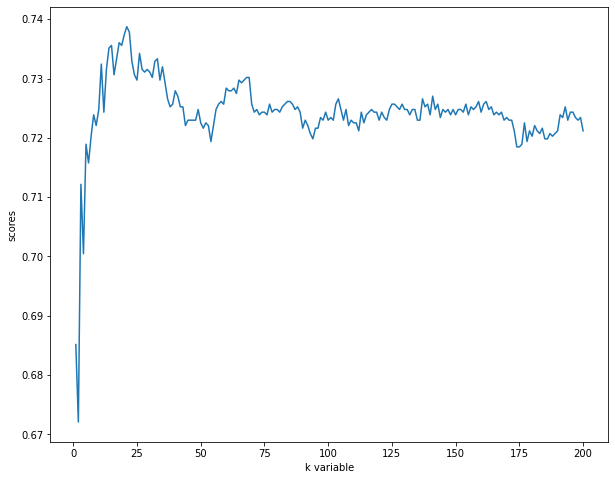

[0.78  0.825 0.715 ... 0.63  0.61  0.82 ]


<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

scores = []
for k in range(1, 201):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(train_data, train_labels)
    scores.append(classifier.score(test_data, test_labels))

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(range(1, 201), scores)
plt.xlabel('k variable')
plt.ylabel('scores')
plt.show()
plt.clf()

# we can see with this graph that the k better value is around 21 or 22
print(classifier.predict_proba(test_data)[:,1])